## Optimizing LLM Inference - Connect to a T4 GPU instance!

In [ ]:
!pip install -qU together transformers torch torchvision matplotlib

In [2]:
import time
from transformers import AutoTokenizer
from together import Together

#client = Together(api_key = "---")
client = Together()

# Steps of LLM Inference:
- Pre-fill: Prompt goes in
- Decode: Output tokens come out auto-regressively

In [ ]:
prompt = "How many r's in the word strawberry?"

tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1", trust_remote_code=True)

decode_text = ""
decode_started = False

#record start time
start_time = time.time()

completion = completion = client.chat.completions.create(
    model="deepseek-ai/DeepSeek-R1",
    messages=[{"role": "user", "content": prompt}],
    stream=True
    )

for chunk in completion:
    if chunk.choices:
        decode_text += chunk.choices[0].delta.content
        print(chunk.choices[0].delta.content or "", end="", flush=True)
        if not decode_started:
            # record decode start time
            decode_started_time = time.time()
            decode_started = True

# record endtime
end_time = time.time()

In [ ]:
# input and output tokens
prefill_tokens_len = len(tokenizer.encode(prompt)) # num input toks
decode_tokens_len = len(tokenizer.encode(decode_text)) # num output tokens

# input(prefill) and output(decode) time
decode_time = end_time - decode_started_time
prefill_time = decode_started_time - start_time

# tokens/per sec (TPS)
prefill_throughput = prefill_tokens_len / prefill_time
decode_throughput = decode_tokens_len / decode_time

print("\n\n<========DECODING STATS========>\n\n")
print(f"Time to first token (TTFT - Prefill time): {prefill_time:.2f} sec")
print(f"Decode time: {decode_time:.2f} sec\n\n")

print(f"Prefill throughput: {prefill_throughput:.2f} tokens/sec")
print(f"Decode throughput(TPS): {decode_throughput:.2f} tokens/sec")

### Tokens per second

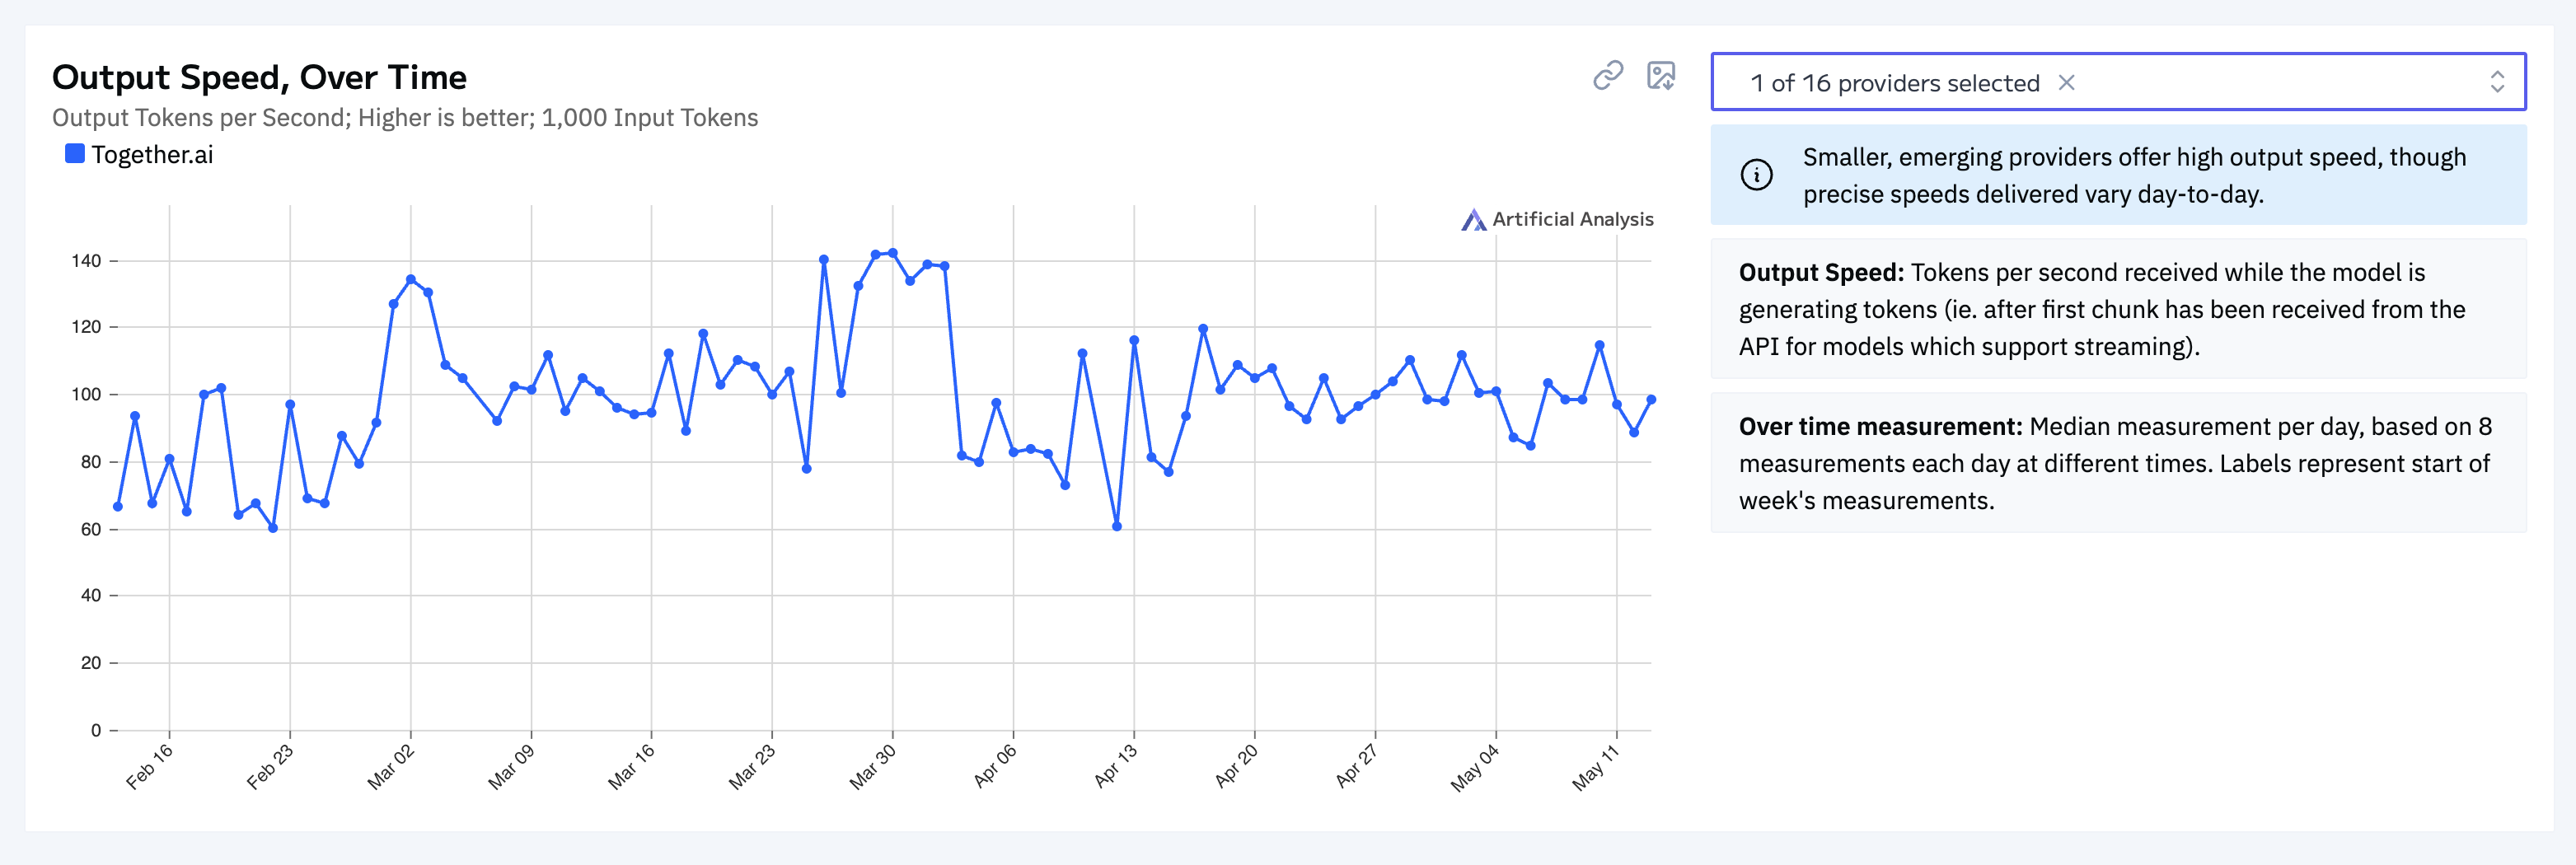

### Time to first token

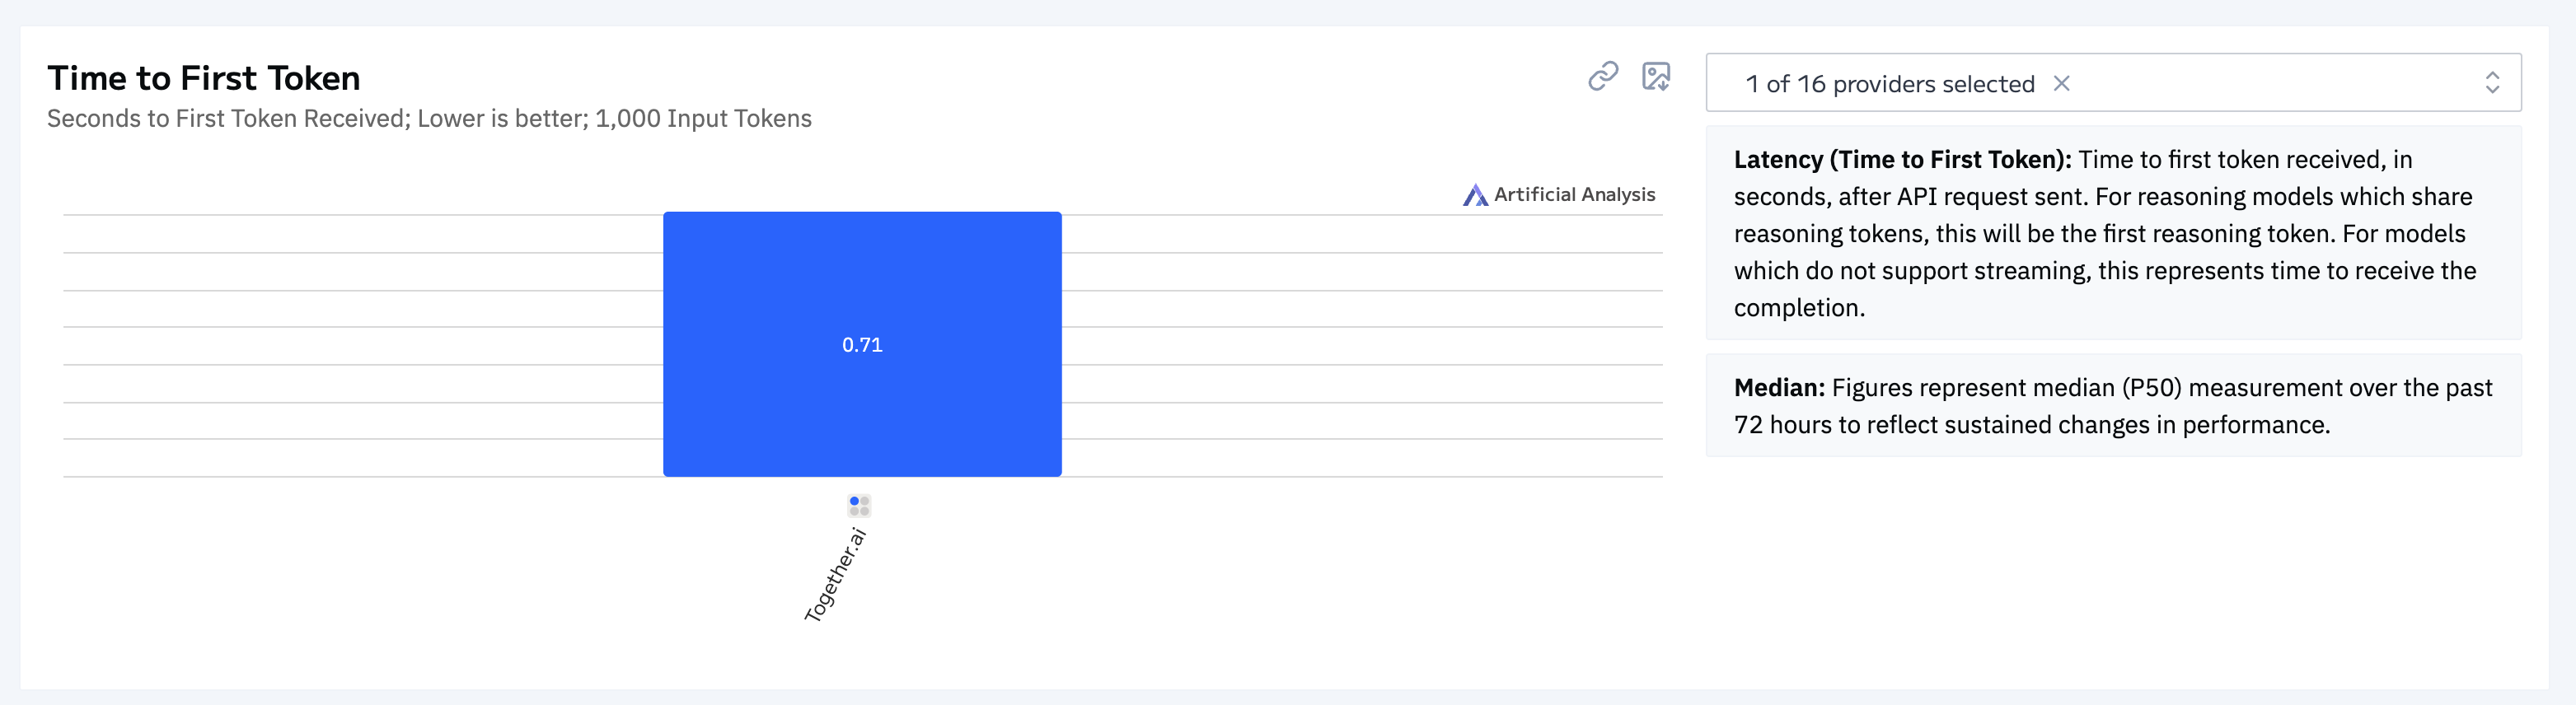

# Speculative Decoding

[Source](https://github.com/tanishqkumar/beyond-nanogpt/tree/main)

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# basic setup, get models we'll use, feel free to replace with any (draft, target) pair you like
# of course, draft should be smaller/faster than target to see speedup
DRAFT_NAME = "Qwen/Qwen2.5-0.5B-Instruct"
TARGET_NAME = "Qwen/Qwen2.5-1.5B-Instruct"

target = AutoModelForCausalLM.from_pretrained(
    TARGET_NAME,
    device_map="auto",
    trust_remote_code=True
)
draft = AutoModelForCausalLM.from_pretrained(
    DRAFT_NAME,
    device_map="auto",
    trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained(DRAFT_NAME, trust_remote_code=True)

prompt = "Hello, how are you?"

# sanity check that forward pass of both is working
input_target = tokenizer(prompt, return_tensors="pt").to("cuda")
with torch.no_grad():
    output_target = target(**input_target)

input_draft = tokenizer(prompt, return_tensors="pt").to("cuda")
with torch.no_grad():
    output_draft = draft(**input_draft)

# we don't want to use hf model.generate, so we populate it with a dummy method
def dummy_generate(*args, **kwargs):
    raise NotImplementedError("generate() method has been disabled")

draft.generate = dummy_generate
target.generate = dummy_generate

In [ ]:
from time import time
from tqdm import tqdm
import torch.nn.functional as F

# syntactic sugar
def cat(a, b, c=None):
    if c is not None:
        return torch.cat([a, b, c], dim=1)
    else:
        return torch.cat([a, b], dim=1)

# vanilla autoregressive sampling without speculation (not using KV cache for simplicity)
def generate_vanilla(model, tokenizer, prompt, max_tokens=256, profile=False):
    model.eval()
    c = 0
    start_time = time() if profile else None
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.cuda()

    while c < max_tokens:
        logits = model(input_ids).logits  # b, s, v
        ntp_tensor = torch.argmax(logits[:, -1:], dim=-1)  # greedy sampling
        input_ids = cat(input_ids, ntp_tensor)

        if ntp_tensor.item() == tokenizer.eos_token_id:
            break

        c += 1

    if profile:
        end_time = time()
        elapsed = end_time - start_time
        print(f"Generated {c} tokens in {elapsed:.2f}s")
        print(f"Tokens per second: {c/elapsed:.2f}")

    print(f'{c} big forward passes in vanilla decoding.')
    return tokenizer.decode(input_ids[0], skip_special_tokens=True)

profile = False
# We can see that the number of forward passes through the big model is around 1/3
# when using speculation compared to without. In production this would translate to a
# 2-3x speedup for inference, which is huge since inference is already well optimized
# by using a KV cache and in frontier systems, custom CUDA kernels.
# And of course, the outputs from the two are identical, confirmin correctness. Hurray!

print(generate_vanilla(target, tokenizer, prompt, max_tokens=256, profile=profile))

In [ ]:
# greedy speculation, ie. not sampling but using argmax to go from logits [B, S, D] -> next token predictions [B, S]
def generate_specdec_greedy(draft, target, tokenizer, prompt, num_draft_tokens=7, max_tokens=256, profile=False):
    draft.eval(); target.eval()
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.cuda()  # b, s
    generated_tokens = 0
    num_target_fws = 0
    start_time = time() if profile else None

    while generated_tokens < max_tokens:  # continue until max_tokens accepted
        draft_ids = torch.tensor([[]], dtype=torch.long).cuda()

        # Decode a block of candidate tokens using the draft (small) model.
        for _ in range(num_draft_tokens):
            all_tokens = cat(input_ids, draft_ids)
            logits = draft(all_tokens).logits  # b, s, v
            draft_ids = cat(draft_ids, torch.argmax(logits[:, -1:], dim=-1))  # [1, num_draft_tokens]

        full_seq = cat(input_ids, draft_ids)
        target_logits = target(full_seq).logits[:, :, :]  # b, s, v
        num_target_fws += 1

        target_pred_ids = torch.argmax(target_logits[:, input_ids.shape[1]-1:, :], dim=-1)

        diff = (draft_ids != target_pred_ids[:, :-1]) # last token is prediction for after all draft tokens
        first_disagreement = diff.nonzero(as_tuple=True)[1][0].item() if diff.any() else draft_ids.shape[1]
        input_ids = cat(input_ids, draft_ids[:, :first_disagreement], target_pred_ids[:, first_disagreement:first_disagreement+1])

        generated_tokens += first_disagreement + 1

        # since we're in batch size 1 setting, can just check in this naive way
        if input_ids[:, -1:].item() == tokenizer.eos_token_id:
            break

    if profile:
        end_time = time()
        elapsed = end_time - start_time
        print(f"Generated {generated_tokens} tokens in {elapsed:.2f}s")
        print(f"Tokens per second: {generated_tokens/elapsed:.2f}")

    print(f'{num_target_fws} big forward passes in specdec.')
    return tokenizer.decode(input_ids[0], skip_special_tokens=True)


print(generate_specdec_greedy(draft, target, tokenizer, prompt, max_tokens=256, profile=profile))

# KV-Cache

[Source](https://github.com/tanishqkumar/beyond-nanogpt/tree/main)

In [8]:
import torch
from typing import List

ACT2FN = {
    'relu': torch.nn.functional.relu,
    'gelu': torch.nn.functional.gelu,
    'silu': torch.nn.functional.silu,
    'swish': torch.nn.functional.silu,
}

class Attention(torch.nn.Module): # BSD -> BSD
    def __init__(self, D=768, layer_idx=None, head_dim=64, causal=True, device="cuda", gqa=False):
        super().__init__()
        self.D = D
        self.head_dim = head_dim
        self.gqa = gqa
        assert D % head_dim == 0
        self.nheads = D//head_dim
        self.Wq = torch.nn.Linear(D, D)
        self.Wk = torch.nn.Linear(D, D)
        self.Wv = torch.nn.Linear(D, D)
        self.causal = causal
        self.Wo = torch.nn.Linear(D, D)
        self.device = device
        self.layer_idx = layer_idx

    def forward(self, x: torch.Tensor, kv_cache): # input is [B, S, D]
        B, S, D = x.shape
        # let's make this multi-head now, ie. make each QKV [B, S, D] --> [B, nh, S, hd]

        Q, K, V = self.Wq(x), self.Wk(x), self.Wv(x) # all [B, S, D]

        Q = Q.view(B, S, self.nheads, self.head_dim).transpose(1,2) # [B, nh, S, hd]
        K = K.view(B, S, self.nheads, self.head_dim).transpose(1,2)
        V = V.view(B, S, self.nheads, self.head_dim).transpose(1,2)

        # update kv cache
        layer_idx = self.layer_idx
        if kv_cache is not None and layer_idx is not None:
            # its preallocated, just write to the memory of the cache using state of current_length
            kv_cache.update(layer_idx, K, V)
            K = kv_cache.keys[layer_idx][:, :, :kv_cache.current_length, :]
            V = kv_cache.values[layer_idx][:, :, :kv_cache.current_length, :]

        # [B, nh, S, hd] @ [B, nh, hd, S] -> [B, nh, S, S]
        scale = torch.sqrt(torch.tensor(self.head_dim, dtype=Q.dtype, device=self.device))
        logits = (Q @ K.transpose(-2, -1)) / scale
        if self.causal:
            mask = torch.triu(torch.ones_like(logits), diagonal=1).bool()
            logits_masked = logits.masked_fill(mask, float('-inf'))
        else:
            logits_masked = logits

        A = torch.nn.functional.softmax(logits_masked, dim=-1) # [B, nh, S, S]

        preout = torch.einsum('bnxy,bnyd->bnxd', A, V) # [B, nh, S, S] @ [B, nh, S, hd] -> [B, nh, S, hd]
        preout = preout.transpose(1, 2).reshape(B, S, -1) # [B, nh, S, hd] -> [B, S, nh * hd]

        out = self.Wo(preout) # [B, S, D]
        return out # [B, S, D]

class MLP(torch.nn.Module):
    def __init__(self, D, hidden_multiplier=4, act='swish', device=None):
        super().__init__()
        self.D = D
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.up_proj = torch.nn.Linear(D, D*hidden_multiplier)
        self.down_proj = torch.nn.Linear(D*hidden_multiplier, D)
        self.act = ACT2FN[act]

    def forward(self, x): # BSD -> BSD automatically on last dim
        return self.down_proj(self.act(self.up_proj(x)))

class LN(torch.nn.Module):
    def __init__(self, D, eps=1e-9, device=None):
        super().__init__()
        self.D = D
        self.eps = eps
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.mean_scale = torch.nn.Parameter(torch.zeros(D))
        self.std_scale = torch.nn.Parameter(torch.ones(D))

    def forward(self, x): # x is [B, S, D]
        mean = x.mean(dim=-1, keepdim=True) # [B, S, 1]
        std = (x.var(dim=-1, keepdim=True) + self.eps)**0.5 # [B, S, 1]
        x_norm = (x - mean)/(std)
        return x_norm * self.std_scale + self.mean_scale

class TransformerLayer(torch.nn.Module):
    def __init__(self, D, gqa=False, device=None):
        super().__init__()
        self.D = D
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.attn = Attention(D, gqa=gqa, device=self.device)
        self.mlp = MLP(D, device=self.device)
        self.ln1 = LN(D, device=self.device)
        self.ln2 = LN(D, device=self.device)

    def forward(self, x, kv_cache=None): # x is BSD
        ln1_out = self.ln1(x)
        attn_out = self.attn(ln1_out, kv_cache=kv_cache)
        x = x + attn_out
        ln2_out = self.ln2(x)
        mlp_out = self.mlp(ln2_out)
        x = x + mlp_out
        return x

class PositionalEmbedding(torch.nn.Module):
    def __init__(self, max_seq_len, D, device=None):
        super().__init__()
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.pos_embedding = torch.nn.Parameter(torch.randn(max_seq_len, D))

    def forward(self, x): # x is [B, S, D]
        B, S, D = x.shape
        return x + self.pos_embedding[:S] # Broadcasting handles batch dimension

class EmbeddingLayer(torch.nn.Module):
    # this is just a lookup table
    def __init__(self, vocab_size, D, device=None):
        super().__init__()
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.embedding = torch.nn.Parameter(torch.randn(vocab_size, D))

    def forward(self, x):
        return self.embedding[x]

class UnembeddingLayer(torch.nn.Module):
    # this is just a lookup table that maps embeddings back to logits
    def __init__(self, vocab_size, D, device=None):
        super().__init__()
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.unembedding = torch.nn.Linear(D, vocab_size)

    def forward(self, x): # x is [B, S, D]
        # Return logits of shape [B, S, vocab_size]
        return self.unembedding(x)

class Transformer(torch.nn.Module):
    def __init__(self, depth, hidden_dim, vocab_size, max_seq_len=16384, device=None, gqa=False):
        super().__init__()
        self.depth = depth
        self.hidden_dim = hidden_dim
        self.emb = EmbeddingLayer(vocab_size, hidden_dim, device=device)
        self.pos_emb = PositionalEmbedding(max_seq_len, hidden_dim, device=device)
        self.unemb = UnembeddingLayer(vocab_size, hidden_dim, device=device)
        self.gqa = gqa
        self.layers = torch.nn.ModuleList([TransformerLayer(hidden_dim, gqa, device=device) for _ in range(depth)])
        for i, layer in enumerate(self.layers):
            layer.attn.layer_idx = i
        self.device = device

    def forward(self, x, kv_cache=None):
        x = self.emb(x)
        if kv_cache is not None:
            # When decoding, only add positional embeddings for the new tokens.
            pos_offset = kv_cache.current_length
            pos_emb = self.pos_emb.pos_embedding[pos_offset: pos_offset + x.size(1)].unsqueeze(0)
            x = x + pos_emb
        else:
            x = self.pos_emb(x)
        for i, layer in enumerate(self.layers):
            x = layer(x, kv_cache=kv_cache)
        x = self.unemb(x)
        return x

In [9]:
# kv cache implementation and profiling
class KVCache:
    """
    minimal kv cache for transformer models that preallocates memory for k/v pairs.
    k/v tensors have shape: [batch_size, num_heads, max_seq_len, head_dim]
    """
    def __init__(self, num_layers: int, batch_size: int, num_heads: int, head_dim: int, max_seq_len: int, device='cuda'):
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.max_seq_len = max_seq_len
        self.device = device
        self.current_length = 0
        # preallocate cache memory for each layer
        self.keys = [
            torch.empty(batch_size, num_heads, max_seq_len, head_dim, device=device)
            for _ in range(num_layers)
        ]
        self.values = [
            torch.empty(batch_size, num_heads, max_seq_len, head_dim, device=device)
            for _ in range(num_layers)
        ]

    def update(self, layer: int, new_keys: torch.Tensor, new_values: torch.Tensor):
        """
        updates cache for a layer with new k/v tensors of shape:
        [batch_size, num_heads, token_count, head_dim]
        """
        seq_offset = self.current_length
        token_count = new_keys.size(2)
        self.keys[layer][:, :, seq_offset:seq_offset + token_count, :] = new_keys
        self.values[layer][:, :, seq_offset:seq_offset + token_count, :] = new_values


class TransformerGenerator:
    """
    fast autoregressive inference using preallocated kv cache. model must accept
    'kv_cache' arg in forward() to load/append k/v pairs from cache
    """
    def __init__(self, model: Transformer, max_seq_len: int=4096):
        self.model = model
        self.device = next(model.parameters()).device
        self.max_seq_len = max_seq_len
        self.kv_cache = None

    def _initialize_cache(self, batch_size: int):
        # extract attn params from first layer to set up cache dims
        first_layer = self.model.layers[0]
        attn = first_layer.attn

        num_heads = attn.num_kv_heads if (hasattr(attn, 'gqa') and attn.gqa) else attn.nheads
        head_dim = attn.head_dim

        self.kv_cache = self.model.kv_cache = KVCache(
            self.model.depth,
            batch_size,
            num_heads,
            head_dim,
            self.max_seq_len,
            self.device
        )

    def _prefill(self, prompt: List[int]):
        # process initial prompt (shape [1, seq_len]) to fill kv cache
        prompt_tensor = torch.tensor(prompt, device=self.device).unsqueeze(0)
        batch_size = prompt_tensor.size(0)
        self._initialize_cache(batch_size)
        _ = self.model(prompt_tensor, kv_cache=self.kv_cache)
        self.kv_cache.current_length = prompt_tensor.size(1)
        return self.kv_cache

    def generate(self, prompt: List[int], max_new_tokens: int):
        """
        generates tokens autoregressively given a prompt
        returns: list[int] with prompt + new tokens
        """
        kv_cache = self._prefill(prompt)
        generated = list(prompt)
        for _ in range(max_new_tokens):
            # feed last token through model, shape [1,1]
            input_tensor = torch.tensor([[generated[-1]]], device=self.device)
            logits = self.model(input_tensor, kv_cache=kv_cache)
            next_token = int(torch.argmax(logits[:, -1, :], dim=-1).item())
            generated.append(next_token)
            kv_cache.current_length += 1
        return generated

In [ ]:
import os
import sys
import time
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# this profiling takes ~10min on a single H100, you can reduce any of the below to make it faster
# (hidden_dim, num_layers, input_seq_len, num_decode_tokens, n_runs)
vocab_size = 256
hidden_dim = 512
n_layers = 6
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Transformer(depth=n_layers, hidden_dim=hidden_dim, vocab_size=vocab_size, device=device)
model = model.to(device)
model.eval()

generator = TransformerGenerator(model)

input_seq_len = 512
num_decode_tokens = [512]#, 2048, 4096, 8192]
decode_times_no_kv = []
decode_times_kv = []
n_runs = 1

with torch.no_grad():
    for n_tokens in tqdm(num_decode_tokens):
        batch_size = 1
        times_for_this_n_no_kv = []
        times_for_this_n_kv = []

        for _ in range(n_runs):
            prompt_tensor = torch.randint(0, vocab_size, (batch_size, input_seq_len)).to(device)
            prompt_list = prompt_tensor.squeeze(0).tolist()

            x = prompt_tensor.clone()
            start_time_no_kv = time.time()
            for _ in range(n_tokens):
                logits = model(x)
                # get next token prediction [B, 1]
                next_token = torch.argmax(logits[:, -1:, :], dim=-1)
                x = torch.cat([x, next_token], dim=1)
            torch.cuda.synchronize()
            end_time_no_kv = time.time()
            times_for_this_n_no_kv.append((end_time_no_kv - start_time_no_kv) * 1000)

            start_time_kv = time.time()
            _ = generator.generate(prompt_list, n_tokens)
            torch.cuda.synchronize()
            end_time_kv = time.time()
            times_for_this_n_kv.append((end_time_kv - start_time_kv) * 1000)

        avg_time_no_kv = np.mean(times_for_this_n_no_kv)
        decode_times_no_kv.append(avg_time_no_kv)
        avg_time_kv = np.mean(times_for_this_n_kv)
        decode_times_kv.append(avg_time_kv)

plt.figure(figsize=(10, 6))
plt.plot(num_decode_tokens, decode_times_no_kv, marker='o', label='No KV Cache')
plt.plot(num_decode_tokens, decode_times_kv, marker='s', label='With KV Cache')
plt.xlabel('Number of Decoded Tokens')
plt.ylabel('Total Time (ms)')
plt.title(f'Decoding Latency vs Number of Generated Tokens\n(Input Length: {input_seq_len}, Averaged over {n_runs} runs)')
plt.grid(True)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

print(f"\nAverage time per decoded token (averaged over {n_runs} runs):")
print("----------------------------------------------------")
print("Decoding Method | Tokens Decoded | Avg ms/token")
print("----------------------------------------------------")
for n_tokens, total_time_no_kv, total_time_kv in zip(num_decode_tokens, decode_times_no_kv, decode_times_kv):
    avg_per_token_no_kv = total_time_no_kv / n_tokens if n_tokens > 0 else 0
    avg_per_token_kv = total_time_kv / n_tokens if n_tokens > 0 else 0
    print(f"No KV Cache     | {n_tokens:14d} | {avg_per_token_no_kv:12.2f}")
    print(f"With KV Cache   | {n_tokens:14d} | {avg_per_token_kv:12.2f}")
    print("----------------------------------------------------")

# Hurray! We can see that without KV cache, decoding latency is nonlinear (it will be quadratic if you zoom out more)
# but with KV cache, decoding latency is linear in sequence length, so this is a O(S) big win!